In [1]:
# %autosave 60
from IPython.display import display, HTML
# display(HTML("<style>.container { width:98.6% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

import os, sys, traceback
os.environ["OPENBLAS_NUM_THREADS"] = "16"

from copy import deepcopy as copy
import numpy as np
# from scipy.ndimage import gaussian_filter
# from scipy.signal import savgol_filter
from astropy.io import fits
# from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath("/lwk/xychen/AKARI_ULIRG/SEDFit/"))
from s3fit_v1 import lamb_air_to_vac, FitFrame, Calzetti00_ExtLaw

In [3]:
v0_redshift = 0.4684

ang_dist = cosmo.kpc_proper_per_arcmin(v0_redshift).to('kpc/arcsec').value
# luminosity distance conversion
lum_dist = cosmo.luminosity_distance(v0_redshift).to('cm').value
lum_area = 4*np.pi * lum_dist**2 # in cm2

lum_sun = const.L_sun.to('erg/s').value
vel_c = const.c.to('km/s').value

In [26]:
# obj_name = 'J1126'
# pixwidth_arcsec = 0.05 # in arcsec
# pixwidth_kpc = pixwidth_arcsec * ang_dist # in kpc 
# flux_scale = 1e-15 # this is 1/org_fden_wyx_h['FLUXSCAL']

# dir_aux = '/lwk/xychen/AKARI_ULIRG/GMOS/J1126/process/rss/data/'
# # read segment maps
# rss_seg_myx = fits.open(dir_aux + f'{obj_name}_rss_mix_seg_myx.fits.gz', ignore_missing_simple=True)[0].data

# # read rss spectra
# rss_Ispec_mns_sw = fits.open(dir_aux + f'{obj_name}_rss_mix_Ispec_mns_sw.fits.gz', ignore_missing_simple=True)
# rss_Fspec_mns_sw = rss_Ispec_mns_sw[0].data * pixwidth_arcsec**2
# rss_Fserr_mns_sw = rss_Ispec_mns_sw[1].data * pixwidth_arcsec**2
# # convert unit of 1e-15 erg/s/cm2/AA/arcsec2 (specific intensity) to 1e-15 erg/s/cm2/AA (specific flux)
# tmp_rss_h = rss_Ispec_mns_sw[0].header
# rss_wave_w = tmp_rss_h['CRVAL1'] + tmp_rss_h['CDELT1']*(np.arange(tmp_rss_h['NAXIS1'])+1-tmp_rss_h['CRPIX1'])
# rss_wave_w = lamb_air_to_vac(rss_wave_w) # to match model spectra in vacuum wavelength

# fits.PrimaryHDU(np.vstack((rss_wave_w, rss_Fspec_mns_sw[-1]*flux_scale, rss_Fserr_mns_sw[-1]*flux_scale))).writeto(
#     obj_name+'_intspec_tw.fits', overwrite=True, output_verify='silentfix')

In [21]:
# from scipy.io import readsav
# ssfit = readsav('XMC_wMwF_090_CCCU_J112657.76+163912.0_SSFIT_sed.dat', python_dict=True)

# band_flux_b = ssfit['sed'][0]['best']['fobs'][0] # in mJy
# band_ferr_b = ssfit['sed'][0]['best']['ferr'][0] # already add 10% of flux 
# band_name_b = np.array(['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', 
#                         '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4', 'AKARI_FIS_2'])

# mask_b = np.isin(band_name_b, ['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', 
#                                '2MASS_J', '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4', 
#                                'Spitzer_IRAC_1', 'Spitzer_IRAC_2', 'Spitzer_IRAC_3', 'Spitzer_IRAC_4', 'Spitzer_MIPS_1'])
# (band_ferr_b - band_flux_b/10)[mask_b]

In [4]:
phot_name_b = np.array(['SDSS_up', 'SDSS_gp', 'SDSS_rp', 'SDSS_ip', 'SDSS_zp', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'WISE_1', 'WISE_2', 'WISE_3', 'WISE_4'])
phot_flux_b = np.array([5.5153001e-02, 8.1697002e-02, 1.6868000e-01, 2.3030201e-01,
       2.9083699e-01, 2.6506501e-01, 5.1317799e-01, 6.0935998e-01,
       6.5717798e-01, 7.9932898e-01, 1.6560427e+01, 9.2305588e+01])
phot_ferr_b = np.array([5.37700020e-04, 7.42999837e-05, 7.90003687e-05, 1.22798607e-04,
       1.38930045e-03, 4.11554985e-02, 2.27502026e-02, 1.14961006e-01,
       2.30419636e-03, 2.99510360e-03, 3.06923389e-02, 3.02008629e-01])

phot_trans_dir='../filters/'

In [6]:
intspec_all_tw = fits.open('J1126_intspec_tw.fits')[0].data
spec_wave_w = intspec_all_tw[0]
spec_flux_w = intspec_all_tw[1]
spec_ferr_w = intspec_all_tw[2]

spec_valid_range = [[4950, 5074], [5120, 5240], [5280, 6420], [6500, 10050]]
spec_R_inst = 631 / 0.31 * 0.5
spec_flux_scale = 1e-15

In [48]:
# fitting model
ssp_file = '/lwk/xychen/AKARI_ULIRG/GMOS/ifufit_code/ssp/popstar21_stellar_nebular_fullwave.fits'
ssp_pmmc = [[[0, -1000, 1000], [600, 100, 1200], [0.5, 0, 5.0], '5.5e-3, None, solar_met']]
# ssp pars: voff, fwhm, AV; population set
agn_pmmc = [[[0, -1000, 1000], [600, 100, 1200], [3.0, 1.5, 10.0], [-1.7, -1.7, -1.7], 'powerlaw']]
# agn pars: voff, fwhm, AV; alpha_lambda of powerlaw
el_pmmc = [[[    0, -500,  500], [ 500,250, 750], [3.0,0,5], [1.2,0.5,1.45], 'NLR:all'], 
           [[ -500,-2000,  100], [1000,750,2500], [1.5,0,5], [1.2,0.5,1.45], 'outflow_1:all'], 
           [[-2500,-3000,-2000], [1000,750,2500], [1.5,0,5], [1.2,0.5,1.45], 'outflow_2:[OIII]a,[OIII]b,[NII]a,Ha,[NII]b']]
# el pars: voff, fwhm, AV, SIIa/b (n_e: 1e4--1cm-3); 3 kinematic system
torus_disc_file = '../models/skirtor_disc_allincl_p1_nosca_q5.dat'
torus_dust_file = '../models/skirtor_torus_allincl_p1_nosca_q5.dat'
torus_pmmc = [[[0, -1000, 1000], [5, 3, 11], [30, 10, 80], [20, 10, 30], [50, 0, 90], 'dust']] #'disc+dust'
# torus pars: voff, tau, opening angle, radii ratio, inclination angle

FF = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
              spec_valid_range=spec_valid_range, spec_R_inst=spec_R_inst, spec_flux_scale=spec_flux_scale, 
              phot_name_b=phot_name_b, phot_flux_b=phot_flux_b, phot_ferr_b=phot_ferr_b, phot_trans_dir=phot_trans_dir,
              v0_redshift=v0_redshift, 
              ssp_pmmc=ssp_pmmc, ssp_file=ssp_file, 
              el_pmmc=el_pmmc, 
              # agn_pmmc=agn_pmmc, 
              torus_pmmc=torus_pmmc, torus_disc_file=torus_disc_file, torus_dust_file=torus_dust_file, 
              num_mock_loops=30, fitraw=True, plot=0, verbose=False)

v6, 250121: (1) S3Fit
Photometric data in bands: ['SDSS_up' 'SDSS_gp' 'SDSS_rp' 'SDSS_ip' 'SDSS_zp' '2MASS_J' '2MASS_H'
 '2MASS_Ks' 'WISE_1' 'WISE_2' 'WISE_3' 'WISE_4']
Spec models wavelength range (rest): 2972.201827240925 7484.315237939023
SED models wavelength range (rest): 1649.891797813306 239970.85955593377
SSP models normalization wavelength: 5500 +- 25
SSP models number: 73 used in 424
SSP models age range (Gyr): 0.005754399373371567 7.943282347242822
SSP models metallicity (Z/H): [0.02]
Emission line complex 0 NLR , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 1 outflow_1 , total number: 30 , free lines: ['Ha' 'HeI' '[SII]b' '[NII]b' '[OI]a' '[NI]b' '[FeVI]' '[OIII]b'
 '[NeIII]a' '[OII]b' '[NeV]b']
Emission line complex 2 outflow_2 , total number: 5 , free lines: ['Ha' '[NII]b' '[OIII]b']
Valid data wavelength range: [[4950, 5074], [5120, 5240], [5280, 6420], [6500, 10050]]


In [ ]:
FF.main_fit()

#### loop 0/30 start: ####
#### fit the raw spectrum (non-mocked) ####
Continual models: ssp
Number of used SSP models: 8
fit_ntry=1, chi_sq=1.815
**** Spec Fit, init continua (cont_fit_init), 10.3 s; totally spent, 10.3 s ****
fit_ntry=1, chi_sq=2.041
**** Spec Fit, init emission lines (el_fit_init), 3.2 s; totally spent, 13.5 s ****
Number of used SSP models: 14
fit_ntry=1, chi_sq=1.920
**** Spec Fit, update continua (cont_fit_1), 11.5 s; totally spent, 25.0 s ****
fit_ntry=1, chi_sq=1.917
**** Spec Fit, update emission lines (el_fit_1), 4.3 s; totally spent, 29.3 s ****
fit_ntry=1, poor fit with chi_sq=1.927 > 1.918 (accepted); available min chi_sq=1.927
fit_ntry=2, poor fit with chi_sq=1.927 > 1.918 (accepted); available min chi_sq=1.927


# Output best-fit parameters

In [34]:
FF.output_ssp_to_screen()


Best-fit single stellar populations
-----------------------------------------------------------
|  ID  |   Age   |  Met   | Coeff  | Coeff.rms | log(M/L) |
-----------------------------------------------------------
| 0236 |  0.0060 | 0.0200 | 0.2261 |       nan |   2.3737 |
| 0237 |  0.0065 | 0.0200 | 0.1886 |       nan |   2.3576 |
| 0239 |  0.0072 | 0.0200 | 0.1528 |       nan |   2.3122 |
| 0245 |  0.0087 | 0.0200 | 0.1100 |       nan |   2.4812 |
| 0246 |  0.0089 | 0.0200 | 0.1093 |       nan |   2.5491 |
| 0275 |  0.0501 | 0.0200 | 0.2132 |       nan |   2.9844 |
-----------------------------------------------------------

Best-fit stellar components
| REDSHIFT = 0.4684 +/- nan
| SIGMA =   325.26 +/- nan
| AV = 1.6048 +/- nan
| log(AGE)_LW = -1.9698 +/- nan
| log(AGE)_MW = -1.7145 +/- nan
| log(MET)_LW = -1.6990 +/- nan
| log(MET)_MW = -1.6990 +/- nan
| M/L5500 =   405.48 +/- nan



In [39]:
# results in the array, FF.output_ssp_lp
# _lp denotes the results are stored in format of [i_loop, i_par], 
# where i_loop and i_par denote the index of each mock loop and each parameters
# parameters: (0) chi_sq (1) ssp_voff (km/s) (2) ssp_fwhm (km/s) (3) ssp_AV 
# (4) redshift (5) flux5500 (spec_flux_scale * erg/s/cm2/AA) (6) mass (Msun) to lum5500 (Lsun/AA) ratio
# (7) log lum-weight age (Gyr) (8) log mass-weight age (Gyr)
# (9) log lum-weight metallicity (Z/H) (10) log mass-weight metallicity (Z/H)
# (11--434) flux (spec_flux_scale * erg/s/cm2/AA) of ssp models

# example
print('Best-fit redshift from stellar continuum:', FF.output_ssp_lp[:,4].mean(), '+-', FF.output_ssp_lp[:,4].std())

Best-fit redshift from stellar continuum: 0.4684199913703688 +- 0.0


In [40]:
FF.output_el_to_screen()


Best-fit emission line components
----------------------------------------------------------------------------------------------------------
|   Par/Line Name    |       Kin_0        |       Kin_1        |       Kin_2        |       Kin_3        |
----------------------------------------------------------------------------------------------------------
|       Chi^2        |     0.12 +-    nan |     0.00 +-    nan |     0.00 +-    nan |     0.00 +-    nan |
|        Voff        | -  27.34 +-    nan | -1011.10 +-    nan | -2476.90 +-    nan |    66.48 +-    nan |
|        FWHM        |   532.87 +-    nan |  1467.70 +-    nan |  1948.80 +-    nan |  5718.93 +-    nan |
|         AV         |     2.67 +-    nan |     1.42 +-    nan |     3.32 +-    nan |     3.32 +-    nan |
|      [SII]a/b      |     1.05 +-    nan |     1.45 +-    nan |     1.22 +-    nan |     0.92 +-    nan |
|     Ha 6564.63     |     4.84 +-    nan |     2.90 +-    nan |     0.00 +-    nan |     3.12 +-    nan |
| 

In [46]:
# results in the array, FF.output_el_lcp
# _lp denotes the results are stored in format of [i_loop, i_comp, i_par], 
# where i_loop, i_comp and i_par denote the index of each mock loop, each component, and each parameters
# components: NLR, outflow_1, outflow_2 (in this test case)
# parameters: (0) chi_sq (1) voff (km/s) (2) fwhm (km/s) (3) AV (from Balmer decrement) (4) [SII]6716/6731 ratio
# (5--) flux (spec_flux_scale * erg/s/cm2) of each line

# for example
i_line = np.where(FF.el_mod.line_name_n == line_name)[0][0]+5
print('Best-fit narrow line velocity shift:', FF.output_el_lcp[:,0,1].mean(), '+-', FF.output_el_lcp[:,0,1].std())

line_name = '[OIII]b'
i_line = np.where(FF.el_mod.line_name_n == line_name)[0][0]+5
print('Best-fit [OIII]5007 outflow_1 flux:', FF.output_el_lcp[:,1,i_line].mean(), '+-', FF.output_el_lcp[:,1,i_line].std())

Best-fit narrow line velocity shift: -27.336215156955355 +- 0.0
Best-fit [OIII]5007 outflow_1 flux: 7.9556550955497976 +- 0.0


In [47]:
FF.output_torus_to_screen()


Best-fit Torus components
| Voff = -27.3362 +/- nan
| Tau =    10.99 +/- nan
| OpenAngel = 65.1378 +/- nan
| RadRatio = 25.5727 +/- nan
| Inclination = 89.6822 +/- nan



# Output best-fit spectra

Text(0, 0.5, 'Flux (1e-15 $erg/s/cm2/\\AA$)')

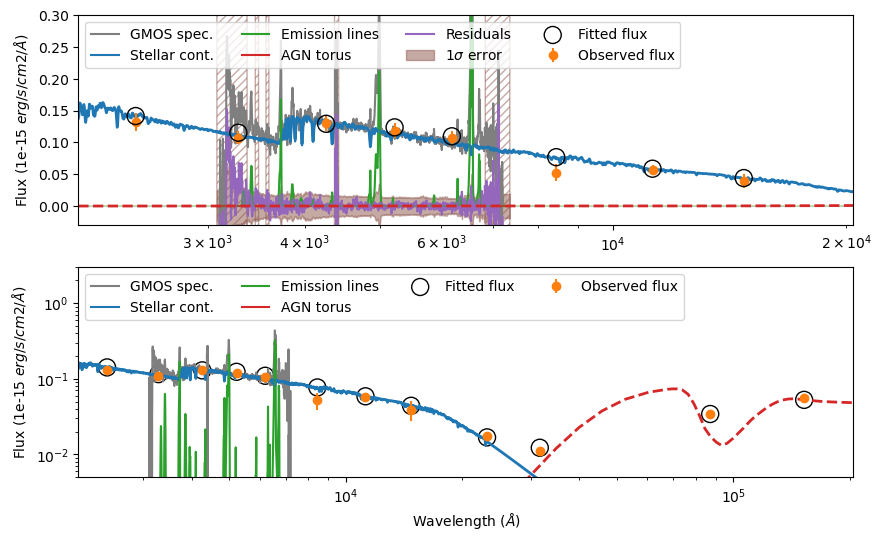

In [28]:
tmp_z = (1+v0_redshift)
sed_wave_w = FF.sed['wave_w']

plt.figure(figsize=(10,6))
ax = plt.subplot(2, 1, 1)
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', label='GMOS spec.')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_ssp_w'], c='C0', label='Stellar cont.')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_el_w'], c='C2', label='Emission lines')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_torus_w'], c='C3', label='AGN torus')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fres_w'], c='C4', alpha=1, label='Residuals')
plt.fill_between(FF.spec['wave_w']/tmp_z, -1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 1*(FF.spec['ferr_w']+0.1*FF.spec['flux_w']), 
                 fc='C5', ec='C5', alpha=0.5, label='1$\sigma$ error')
plt.fill_between(FF.spec['wave_w']/tmp_z, -1*~FF.spec['mask_valid_w'], 1*~FF.spec['mask_valid_w'], 
                 hatch='////', fc='None', ec='C5', alpha=0.5)

for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:], '-', c='C0', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:], '-', c='C2', linewidth=.5, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:], '--', c='C3', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))

plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], (FF.phot['ferr_b']+0.1*FF.phot['flux_b'])*1, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='k', s=150, label='Fitted flux', zorder=20 )

plt.legend(ncol=4, loc=2)
plt.ylim(-0.03,0.3)
plt.xlim(3e3/tmp_z,3e4/tmp_z) 
plt.xscale('log')
plt.ylabel('Flux ('+str(spec_flux_scale)+' $erg/s/cm2/\AA$)')

ax = plt.subplot(2, 1, 2)
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] , c='C7', label='GMOS spec.')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_ssp_w'], c='C0', label='Stellar cont.')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_el_w'], c='C2', label='Emission lines')
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['fmod_torus_w'], c='C3', label='AGN torus')

for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:], '-', c='C0', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:], '-', c='C2', linewidth=.5, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:], '--', c='C3', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))

plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'], 
            (FF.phot['ferr_b']+0.1*FF.phot['flux_b'])*1, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'], marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=4, loc=2)
plt.ylim(0.005,3)
plt.xlim(3e3/tmp_z,3e5/tmp_z) 
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux ('+str(spec_flux_scale)+' $erg/s/cm2/\AA$)')

Text(0, 0.5, 'Flux (mJy))')

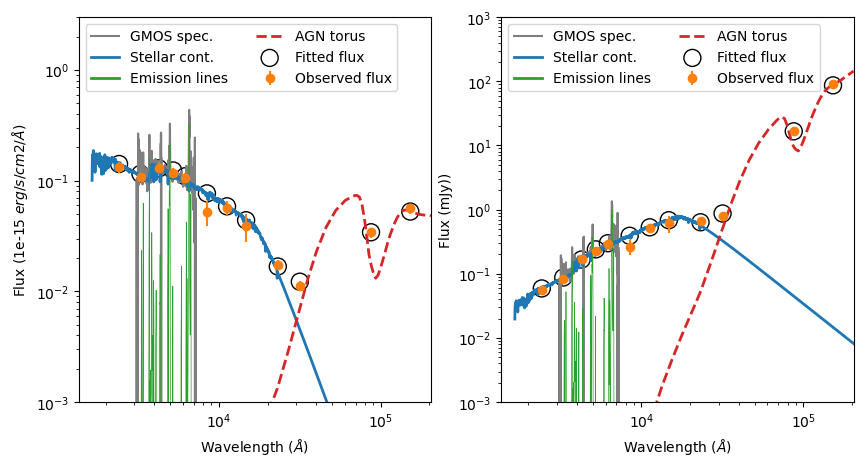

In [30]:
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 2, 1)
tmp_w = 1
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] * tmp_w , c='C7', label='GMOS spec.')

tmp_w = 1
for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:] * tmp_w, '-', c='C0', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:] * tmp_w, '-', c='C2', linewidth=.5, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:] * tmp_w, '--', c='C3', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

tmp_b = 1
plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'] * tmp_b, 
            (FF.phot['ferr_b']+0.1*FF.phot['flux_b'])*1 * tmp_b, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'] * tmp_b, marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,3); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux ('+str(spec_flux_scale)+' $erg/s/cm2/\AA$)')

ax = plt.subplot(1, 2, 2)
tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.spec['wave_w']) 
plt.plot(FF.spec['wave_w']/tmp_z, FF.spec['flux_w'] * tmp_w , c='C7', label='GMOS spec.')

tmp_w = spec_flux_scale * FF.pframe.rFnuFlam_func(FF.sed['wave_w']) 
for i in range(FF.num_mock_loops):
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,0,:] * tmp_w, '-', c='C0', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,1,:] * tmp_w, '-', c='C2', linewidth=.5, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
    plt.plot(FF.sed['wave_w']/tmp_z, FF.output_sed_ltw[i,2,:] * tmp_w, '--', c='C3', linewidth=2, alpha=np.minimum(1,1/(FF.num_mock_loops/2)))
plt.plot(0,0, '-', c='C0', linewidth=2, label='Stellar cont.')
plt.plot(0,0, '-', c='C2', linewidth=2, label='Emission lines')
plt.plot(0,0, '--', c='C3', linewidth=2, label='AGN torus')

tmp_b = spec_flux_scale * FF.pframe.rFnuFlam_b
plt.errorbar(FF.phot['wave_b']/tmp_z, FF.phot['flux_b'] * tmp_b, 
            (FF.phot['ferr_b']+0.1*FF.phot['flux_b'])*1 * tmp_b, fmt='o', color='C1', label='Observed flux' )
plt.scatter(FF.phot['wave_b']/tmp_z, FF.phot['fmod_b'] * tmp_b, marker='o', color='None', ec='k', s=150, label='Fitted flux')

plt.legend(ncol=2, loc=2)
plt.ylim(0.001,1000); plt.xlim(2e3/tmp_z,3e5/tmp_z)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (mJy))')